In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict Yen futures ("settle") returns with *lagged* Yen futures returns. 

In [2]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("../Resources/yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [3]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


# Data Preparation

### Returns

In [4]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
# YOUR CODE HERE!
yen_futures['Return'] = yen_futures['Settle'].pct_change() * 100
yen_futures = yen_futures.replace(-np.inf, np.nan).dropna()
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Return
Date,,,,,,,,,
2014-02-18,9831.0,9865.0,9734.0,9775.0,42.0,9775.0,203495.0,196924.0,-0.427829
2014-02-19,9768.0,9825.0,9760.0,9773.0,2.0,9773.0,129508.0,197197.0,-0.020460
2014-02-20,9774.0,9837.0,9765.0,9775.0,2.0,9775.0,160202.0,198280.0,0.020465
2014-02-21,9772.0,9776.0,9725.0,9758.0,20.0,9755.0,103091.0,202990.0,-0.204604
2014-02-24,9752.0,9789.0,9740.0,9757.0,2.0,9757.0,90654.0,203114.0,0.020502


### Lagged Returns 

In [5]:
# Create a lagged return using the shift function
# YOUR CODE HERE!
yen_futures['Lagged Return'] = yen_futures['Return'].shift()
yen_futures = yen_futures.dropna()
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Return,Lagged Return
Date,,,,,,,,,,
2014-02-19,9768.0,9825.0,9760.0,9773.0,2.0,9773.0,129508.0,197197.0,-0.020460,-0.427829
2014-02-20,9774.0,9837.0,9765.0,9775.0,2.0,9775.0,160202.0,198280.0,0.020465,-0.020460
2014-02-21,9772.0,9776.0,9725.0,9758.0,20.0,9755.0,103091.0,202990.0,-0.204604,0.020465
2014-02-24,9752.0,9789.0,9740.0,9757.0,2.0,9757.0,90654.0,203114.0,0.020502,-0.204604
2014-02-25,9760.0,9808.0,9744.0,9789.0,32.0,9789.0,105498.0,201486.0,0.327970,0.020502


### Train Test Split

In [6]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = yen_futures[:'2017']
test = yen_futures['2018':]

In [7]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
# YOUR CODE HERE!
X_train = train.drop(columns=['Lagged Return', 'Return'])
X_test = test.drop(columns=['Lagged Return', 'Return'])
y_train = train['Return']
y_test = test['Return']

In [8]:
X_train

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
2014-02-19,9768.0,9825.0,9760.0,9773.0,2.0,9773.0,129508.0,197197.0
2014-02-20,9774.0,9837.0,9765.0,9775.0,2.0,9775.0,160202.0,198280.0
2014-02-21,9772.0,9776.0,9725.0,9758.0,20.0,9755.0,103091.0,202990.0
2014-02-24,9752.0,9789.0,9740.0,9757.0,2.0,9757.0,90654.0,203114.0
2014-02-25,9760.0,9808.0,9744.0,9789.0,32.0,9789.0,105498.0,201486.0
...,...,...,...,...,...,...,...,...
2017-12-22,8871.0,8882.5,8864.5,8880.5,10.5,8881.0,71339.0,230870.0
2017-12-26,8879.0,8898.5,8873.5,8884.5,10.5,8891.5,33864.0,229084.0
2017-12-27,8887.0,8895.0,8869.0,8870.5,13.5,8878.0,86378.0,228295.0


# Linear Regression Model

In [9]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
# YOUR CODE HERE!
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

# Make predictions using the Testing Data

Note: We want to evaluate the model using data that it has never seen before, in this case: X_test.

In [10]:
# Make a prediction of "y" values using just the test dataset
# YOUR CODE HERE!
pred_y = model.predict(X_test)

In [11]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
# YOUR CODE HERE!
actual = pd.DataFrame({'Actual':y_test, 'Predicted':pred_y})
actual.head()

,Actual,Predicted
Date,,
2018-01-02,0.297285,0.315663
2018-01-03,-0.240479,-0.283832
2018-01-04,-0.213028,-0.201315
2018-01-05,-0.353933,-0.324261
2018-01-08,0.062017,0.024706


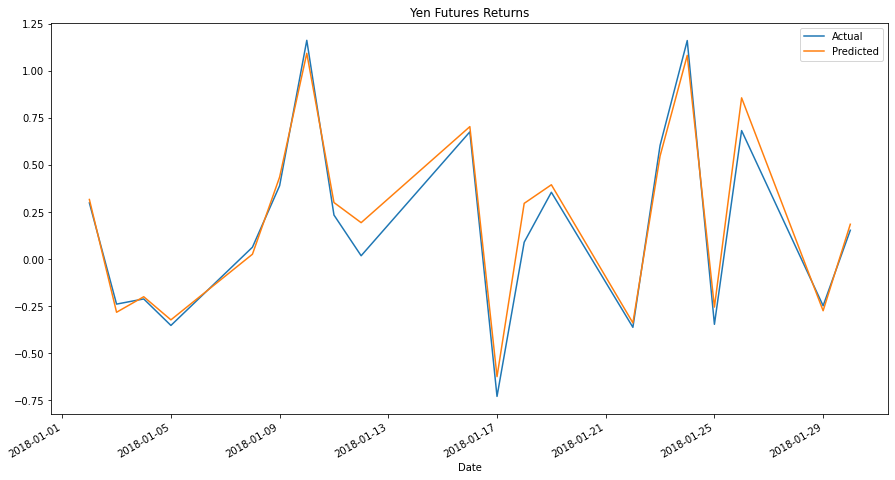

In [12]:
# Plot the first 20 predictions vs the true values
# YOUR CODE HERE!
actual.head(20).plot(
    title='Yen Futures Returns',
    figsize = (15, 8))
plt.savefig('../Resources/returns.png')

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (X_test and y_test)

In [13]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
# YOUR CODE HERE!
mse = mean_squared_error(y_test, pred_y)
# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
# YOUR CODE HERE!
rmse = np.sqrt(mse)
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

MSE: 0.028670527142282663
RMSE: 0.16932373472813156


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

MSE: 0.028670527142282663	In-Sample MSE: 0.026318561247957378
RMSE: 0.16932373472813156	In-Sample RMSE: 0.16222996408788784


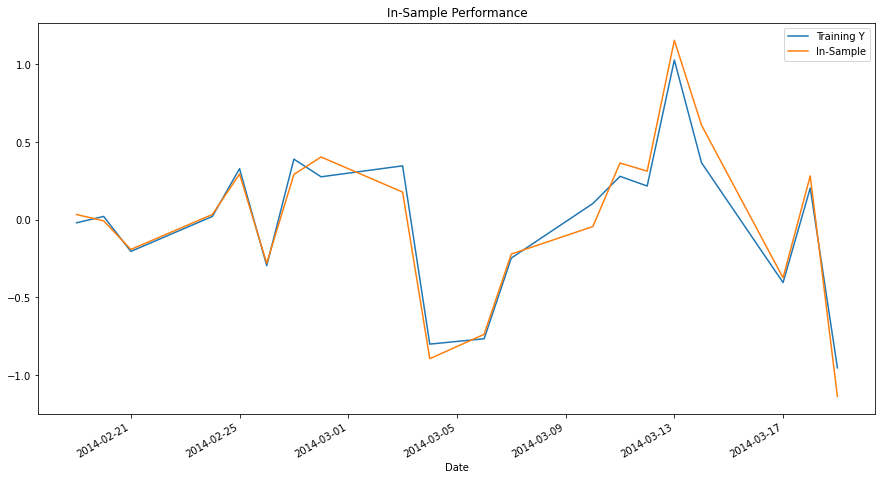

In [14]:
# Construct a dataframe using just the "y" training data:
# YOUR CODE HERE!
in_sample = pd.DataFrame({'Training Y':y_train})
# Add a column of "in-sample" predictions to that dataframe:  
# YOUR CODE HERE!
in_pred_y = model.predict(X_train)
in_sample['In-Sample'] = in_pred_y
in_sample.head(20).plot(
    title='In-Sample Performance',
    figsize = (15, 8))
plt.savefig('../Resources/in_sample.png')
# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
# YOUR CODE HERE!
in_mse = mean_squared_error(y_train, in_pred_y)
# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
# YOUR CODE HERE!
in_rmse = np.sqrt(in_mse)
print(f'MSE: {mse}\tIn-Sample MSE: {in_mse}')
print(f'RMSE: {rmse}\tIn-Sample RMSE: {in_rmse}')


In [16]:
table = pd.DataFrame()
table['Out-of-Sample'] = [mse, rmse]
table['In-Sample'] = [in_mse, in_rmse]
table

,Out-of-Sample,In-Sample
0,0.028671,0.026319
1,0.169324,0.162230


# Conclusions

YOUR CONCLUSIONS HERE!